In [1]:
# This is a Bayesian Neural Network implementation using TensorFlow for a simple y = sin(x) function

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

x shape: (256,)
t shape: (256,)
u0: (256,)
U_1D shape: (256,)
X shape: (256, 256)
T shape: (256, 256)
U shape: (256, 256)


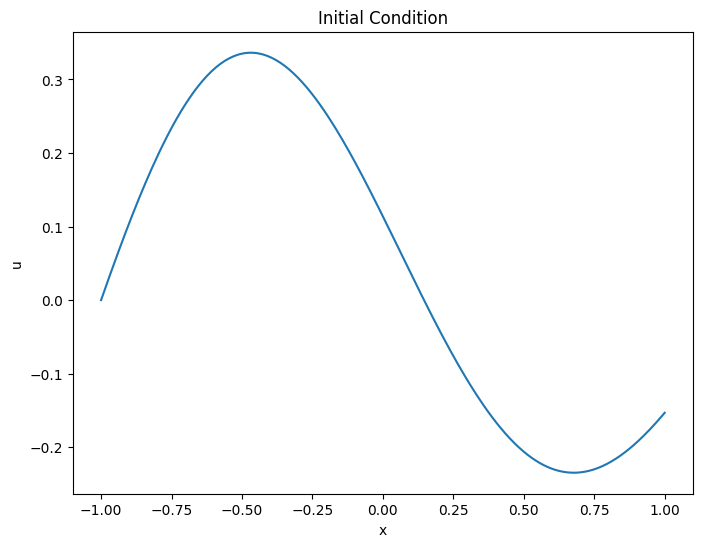

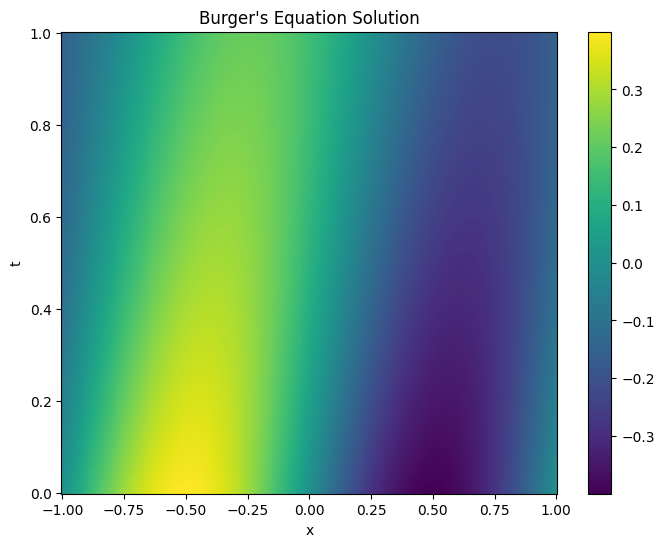

In [6]:
# Define the parameters for the Burger's equation
nu = 0.2 / np.pi  # Viscosity
N = 256  # Number of data points

# Generate the spatial domain
x = np.linspace(-1, 1, N)
t = np.linspace(0, 1, N)
X, T = np.meshgrid(x, t)

# Initial condition
u0 = -np.sin(np.pi * x)

# Generate the dataset
def burgers_exact(x, t, nu):
    return -2 * nu * np.pi * np.sin(np.pi * (x - 4 * nu * t)) * np.exp(-np.pi**2 * nu * t)
# Exact solution: u(x, t) = -2 * nu * pi * sin(pi * (x - 4 * nu * t)) * exp(-pi^2 * nu * t)
# If t = 0, u(x, 0) = -2 * nu * pi * sin(pi * x) = -2 * 0.01/pi * pi * sin(pi * x) = -0.02 * sin(pi * x)
# If t = 1, u(x, 1) = -2 * nu * pi * sin(pi * (x - 4 * nu)) = -2 * 0.01/pi * pi * sin(pi * (x - 4 * 0.01/pi)) = -0.02 * sin(pi * (x - 4 * 0.01/pi))

U_1D = burgers_exact(x, t, nu)
U = burgers_exact(X, T, nu)
#U = U_1D

# Plot sizes of all the data
print("x shape:", x.shape)
print("t shape:", t.shape)
print("u0:", u0.shape)
print("U_1D shape:", U_1D.shape)
print("X shape:", X.shape)
print("T shape:", T.shape)
print("U shape:", U.shape)

plt.figure(figsize=(8, 6))
plt.plot(x, U_1D)
plt.xlabel('x')
plt.ylabel('u')
plt.title('Initial Condition')
plt.show()

# Plot the initial condition
plt.figure(figsize=(8, 6))
plt.pcolormesh(X, T, U, shading='auto')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title("Burger's Equation Solution")
plt.show()

U shape: (256,)
X_tf shape: (256, 1)
U_tf shape: (256, 1)
Epoch 1: Negative Log Posterior = 163.632202
Anti Log Posterior = inf
RMSE: 0.2010394782
----------------------------------------


C:\Users\User\AppData\Local\Temp\ipykernel_61988\681670908.py:131: RuntimeWarning: overflow encountered in exp
  print(f"Anti Log Posterior = {np.exp(loss.numpy()):.6f}")


Epoch 100: Negative Log Posterior = 82.493057
Anti Log Posterior = 670315969520447026564173294701903872.000000
RMSE: 0.1155345216
----------------------------------------
Epoch 200: Negative Log Posterior = 69.616013
Anti Log Posterior = 1713365833884488188031599116288.000000
RMSE: 0.1149379462
----------------------------------------
Epoch 300: Negative Log Posterior = 48.739811
Anti Log Posterior = 1470384605202332254208.000000
RMSE: 0.0907572061
----------------------------------------
Epoch 400: Negative Log Posterior = 22.932793
Anti Log Posterior = 9111404544.000000
RMSE: 0.0307123624
----------------------------------------
Epoch 500: Negative Log Posterior = 16.692093
Anti Log Posterior = 17753494.000000
RMSE: 0.0234941076
----------------------------------------
Epoch 600: Negative Log Posterior = 12.811234
Anti Log Posterior = 366309.406250
RMSE: 0.0201426484
----------------------------------------
Epoch 700: Negative Log Posterior = 10.009441
Anti Log Posterior = 22235.4121

ValueError: x and y can be no greater than 2D, but have shapes (256, 256, 256) and (256, 256, 1)

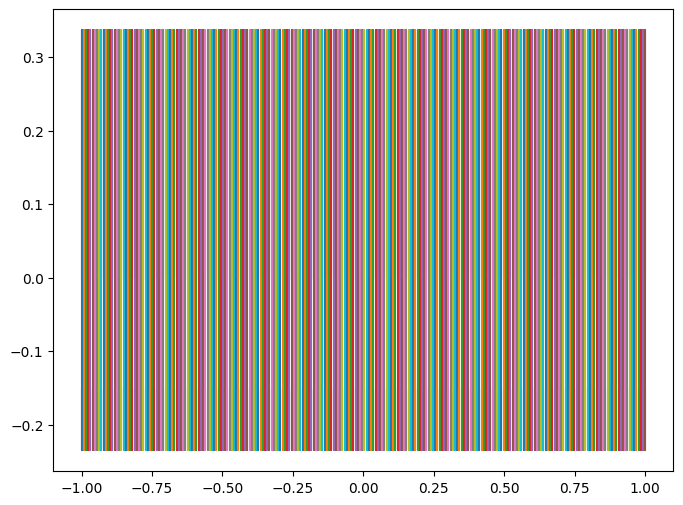

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

hidden1 = 30
# Define the neural network architecture
class BayesianNeuralNetwork:
    def __init__(self, input_dim, hidden1, hidden2, output_dim, prior_std=np.sqrt(50/hidden1)):
        # Initialize weights and biases as TensorFlow variables
        initializer = tf.initializers.GlorotUniform()

        # Define trainable parameters (weights and biases)
        self.weights = [
            tf.Variable(initializer([input_dim, hidden1]), dtype=tf.float32),
            tf.Variable(initializer([hidden1, hidden2]), dtype=tf.float32),
            tf.Variable(initializer([hidden2, output_dim]), dtype=tf.float32)
        ]
        
        self.biases = [
            tf.Variable(tf.zeros([hidden1]), dtype=tf.float32),
            tf.Variable(tf.zeros([hidden2]), dtype=tf.float32),
            tf.Variable(tf.zeros([output_dim]), dtype=tf.float32)
        ]

        # Prior parameters (assuming Gaussian priors)
        self.prior_std = prior_std
        self.prior_vars = [
            tf.constant(self.prior_std**2, dtype=tf.float32) for _ in self.weights + self.biases
        ] # sigma**2. We assume that the prior is N(0, sigma**2).
        # for _ in self.weights + self.biases: create a list of prior_vars with the same length as weights and biases
        # So it creates a list of prior_vars for each weight and bias, total 6 elements in the list
        # The prior_std is the standard deviation of the prior, and we assume that the prior is N(0, sigma**2)

    def forward(self, X):
        # Layer 1 with tanh activation
        hidden1 = tf.matmul(X, self.weights[0]) + self.biases[0]
        hidden1_activation = tf.nn.tanh(hidden1)
        
        # Layer 2 with tanh activation
        hidden2 = tf.matmul(hidden1_activation, self.weights[1]) + self.biases[1]
        hidden2_activation = tf.nn.tanh(hidden2)
        
        # Output layer (linear activation)
        output = tf.matmul(hidden2_activation, self.weights[2]) + self.biases[2]
        return output

    def log_prior(self): # Role: Define initial beliefs about each parameter, acting as regularizers.
        # Compute log prior probability of weights and biases
        log_prior = 0.0
        for var, var_prior_var in zip(self.weights + self.biases, self.prior_vars): 
            # Assuming Gaussian prior: log p(w) = -0.5 * log(2πσ²) - w²/(2σ²)
            #log_prior += -0.5 * tf.reduce_sum(tf.math.log(2.0 * np.pi * var_prior_var**2)) # log(2πσ²)
            log_prior += -tf.reduce_sum(tf.square(var)) / (2.0 * var_prior_var**2) # -w²/(2σ²)
        log_prior_store.append(log_prior)
        return log_prior

    def log_likelihood(self, Y_true, Y_pred, likelihood_std=np.std(U)): # Role: Represents the probability of observing the data given the parameters, modeling how well the network fits the data.
        # Assuming Gaussian likelihood: p(Y|X,w) = N(Y_pred, σ²)
        # log p(Y|X,w) = -0.5 * log(2πσ²) - (Y - Y_pred)^2 / (2σ²)
        #log_likelihood = -0.5 * tf.cast(tf.size(Y_true), tf.float32) * tf.math.log(2.0 * np.pi * likelihood_std**2) # log(2πσ²)
        log_likelihood = 0.0
        log_likelihood += -tf.reduce_sum(tf.square(Y_true - Y_pred)) / (2.0 * likelihood_std**2) # -(Y - Y_pred)^2 / (2σ²)
        log_likelihood_store.append(log_likelihood)
        return log_likelihood

    def log_posterior(self, Y_true, Y_pred): # Role: Combines priors and likelihood to update beliefs about parameters after observing the data.
        # log posterior ∝ log likelihood + log prior
        #print("Likelihood:   ", self.log_likelihood(Y_true, Y_pred))
        #print("Prior:   ", self.log_prior())
        log_posterior_store.append(self.log_likelihood(Y_true, Y_pred) + self.log_prior())
        return self.log_likelihood(Y_true, Y_pred) + self.log_prior()

U = U_1D
print("U shape:", U.shape)  

# Initialize the Bayesian neural network
input_dim = 1
hidden1 = N
hidden2 = N
output_dim = 1
prior_std = 1.0  # Standard deviation for the prior
log_prior_store = []
log_likelihood_store = []
log_posterior_store = []

model = BayesianNeuralNetwork(input_dim, hidden1, hidden2, output_dim)

# Define the loss function (negative log posterior)
def negative_log_posterior(model, U, U_pred):
    # We minimize the negative log posterior
    return -model.log_posterior(U, U_pred)

# Prepare the optimizer
learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate)  # Adam often works better for Bayesian methods

# Training parameters
epochs = 10000
print_interval = 100
best_rmse = float('inf')
loss_all = []

# Convert the data to TensorFlow tensors
X_tf = tf.constant(x.reshape(-1, 1), dtype=tf.float32)
U_tf = tf.constant(U.reshape(-1, 1), dtype=tf.float32)
print("X_tf shape:", X_tf.shape)
print("U_tf shape:", U_tf.shape)

# Training loop
for epoch in range(1, epochs + 1):

    with tf.GradientTape() as tape:
        # Forward pass
        U_pred = model.forward(X_tf)
        # Compute negative log posterior
        loss = negative_log_posterior(model, U_tf, U_pred)
        loss_all.append(loss)
    
    # Compute gradients
    gradients = tape.gradient(loss, model.weights + model.biases) # Purpose of gradient: To update the weights and biases in the direction that minimizes the loss function.
    # Apply gradients
    optimizer.apply_gradients(zip(gradients, model.weights + model.biases))
    
    # Print loss every 'print_interval' epochs
    if epoch % print_interval == 0 or epoch == 1:
        print(f"Epoch {epoch}: Negative Log Posterior = {loss.numpy():.6f}")
        print(f"Anti Log Posterior = {np.exp(loss.numpy()):.6f}")
        rmse_train = tf.sqrt(tf.reduce_mean((U_tf - U_pred)**2))
        print(f"RMSE: {rmse_train.numpy():.10f}")

    # Save weights and biases only if lower rmse than before
    if rmse_train < best_rmse:
        best_rmse = rmse_train
        MAP_weights = model.weights
        MAP_biases = model.biases
        best_epoch = epoch
        if epoch % print_interval == 0 or epoch == 1:
            #print("Improvement in RMSE. Weights and biases saved.")
            print("----------------------------------------")
    else:
        if epoch % print_interval == 0 or epoch == 1:
            print("No improvement in RMSE. Weights and biases not saved.")
            print("----------------------------------------")
    

# After training, plot the model predictions
print(f"Best Epoch at: {best_epoch}")
plt.figure(figsize=(8, 6))
plt.plot(X, U, alpha=1, label='True Data')
# Sort X for better visualization of the prediction curve
sorted_indices = np.argsort(X.squeeze())
X_sorted = X[sorted_indices]
Y_pred_sorted = U_pred.numpy()[sorted_indices]
plt.plot(X_sorted, Y_pred_sorted, color='red', label='Model Prediction', linewidth=2)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Bayesian Neural Network Fit to sin(X)")
plt.legend()
plt.show()

Best epoch at:  9400
RMSE: 0.00023007
Loss: 14.68333435
Anti Log Posterior = 2381722.250000


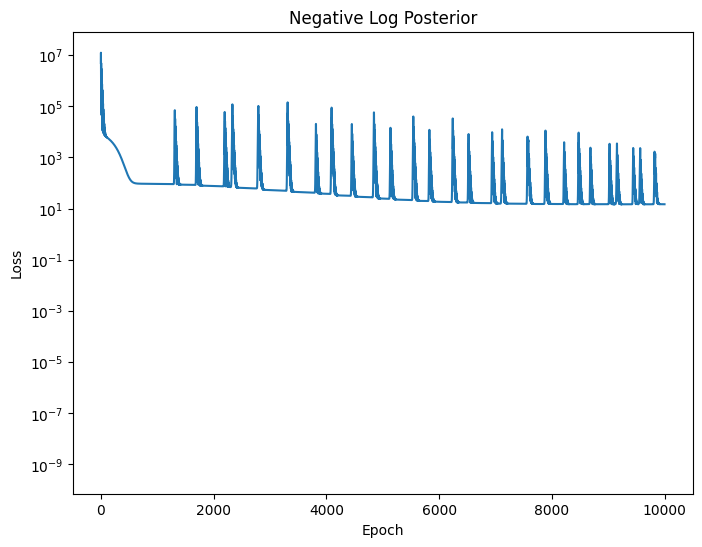

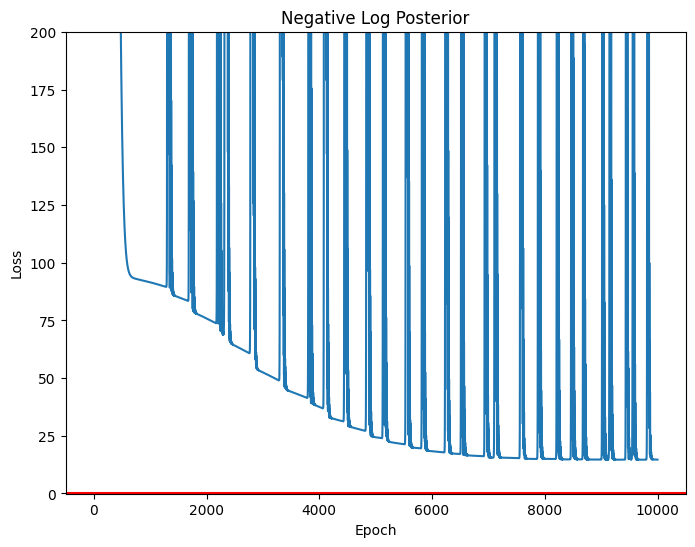

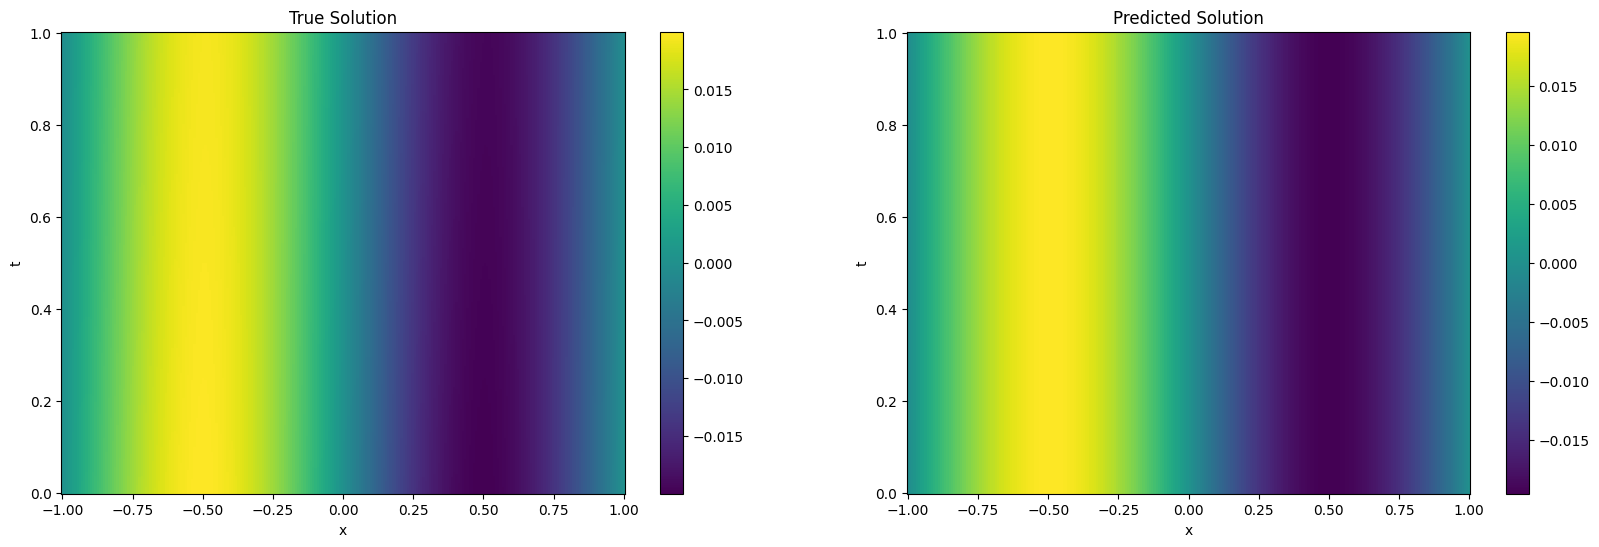

In [33]:
# Print RMSE
model.weights = MAP_weights
model.biases = MAP_biases
U_predd = model.forward(X_tf)
U_predd = U_predd.numpy()
# reshape U_predd to 2D
U_predd = U_predd.reshape(N, N)
rmse = tf.sqrt(tf.reduce_mean(tf.square(U - U_predd)))
print("Best epoch at: ", best_epoch)
print(f"RMSE: {rmse.numpy():.8f}")

# Convert loss to anti-log
print(f"Loss: {(loss.numpy()):.8f}")
print(f"Anti Log Posterior = {np.exp(loss.numpy()):.6f}")

# Plot the loss
plt.figure(figsize=(8, 6))
plt.plot(loss_all)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Negative Log Posterior")
plt.yscale('log')
plt.show()

# Plot loss at y=0 +- 0.1
plt.figure(figsize=(8, 6))
plt.plot(loss_all)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Negative Log Posterior")
plt.ylim(-0.1, 200.1)
plt.show()

# Plot true vs predicted
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.pcolormesh(X, T, U, shading='auto')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title("True Solution")
plt.subplot(1, 2, 2)
plt.pcolormesh(X, T, U_predd, shading='auto')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title("Predicted Solution")
plt.show()

# Next steps:
# 1. Fix the negative log posterior loss and the log scale issue giving 0.0000000000000000
# 2. Look at momentum values
# 3. Look at single weight/bias distributions
# 4. Go to PINN with new problem

In [38]:
def pde_residual(u, x, t, nu):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch([x])
        with tf.GradientTape(persistent=True) as tape:
            tape.watch([x])
            u = model.forward(tf.concat([x], axis=1))
        u_x = tape.gradient(u, x)
    u_xx = tape2.gradient(u_x, x)
    #u_t = tape.gradient(u, t)
    residual = u * u_x - nu * u_xx
    return residual

def pinn_loss(model, x, t, u0, nu):
    # Initial condition loss
    u_pred_initial = model(tf.concat([x, tf.zeros_like(x)], axis=1))
    loss_initial = tf.reduce_mean(tf.square(u_pred_initial - u0))

    # Boundary condition loss
    u_pred_left = model(tf.concat([tf.ones_like(t) * x[0], t], axis=1))
    u_pred_right = model(tf.concat([tf.ones_like(t) * x[-1], t], axis=1))
    loss_boundary = tf.reduce_mean(tf.square(u_pred_left)) + tf.reduce_mean(tf.square(u_pred_right))

    # PDE residual loss
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        u_pred = model(tf.concat([x, t], axis=1))
    residual = pde_residual(u_pred, x, t, nu)
    loss_pde = tf.reduce_mean(tf.square(residual))

    # Total loss
    total_loss = loss_initial + loss_boundary + loss_pde
    return total_loss

In [39]:
# Train

# Initialize the Bayesian neural network
input_dim = 1
hidden1 = N
hidden2 = N
output_dim = 1
prior_std = 1.0  # Standard deviation for the prior
log_prior_store = []
log_likelihood_store = []
log_posterior_store = []

model = BayesianNeuralNetwork(input_dim, hidden1, hidden2, output_dim)

# Prepare the optimizer
learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate)  # Adam often works better for Bayesian methods

# Training parameters
epochs = 10000
print_interval = 100
best_rmse = float('inf')
loss_all = []

# Convert the data to TensorFlow tensors
X_tf = tf.constant(x.reshape(-1, 1), dtype=tf.float32)
U_tf = tf.constant(U.reshape(-1, 1), dtype=tf.float32)

# Training loop
for epoch in range(1, epochs + 1):
    
        with tf.GradientTape() as tape:
            # Forward pass
            U_pred = model.forward(X_tf)
            # Compute negative log posterior
            loss = negative_log_posterior(model, U_tf, U_pred)
            residual = pde_residual(U_pred, X_tf, t, nu)
            loss_pde = tf.reduce_mean(tf.square(residual))
            loss = loss + loss_pde

            loss_all.append(loss)
        
        # Compute gradients
        gradients = tape.gradient(loss, model.weights + model.biases)
        # Apply gradients
        optimizer.apply_gradients(zip(gradients, model.weights + model.biases))
        
        # Print loss every 'print_interval' epochs
        if epoch % print_interval == 0 or epoch == 1:
            print(f"Epoch {epoch}: Negative Log Posterior = {loss.numpy():.6f}")
            print(f"Anti Log Posterior = {np.exp(loss.numpy()):.6f}")
            rmse_train = tf.sqrt(tf.reduce_mean((U_tf - U_pred)**2))
            print(f"RMSE: {rmse_train.numpy():.10f}")
    
        # Save weights and biases only if lower rmse than before
        if rmse_train < best_rmse:
            best_rmse = rmse_train
            MAP_weights = model.weights
            MAP_biases = model.biases
            best_epoch = epoch
            if epoch % print_interval == 0 or epoch == 1:
                #print("Improvement in RMSE. Weights and biases saved.")
                print("----------------------------------------")
        else:
            if epoch % print_interval == 0 or epoch == 1:
                print("No improvement in RMSE. Weights and biases not saved.")
                print("----------------------------------------")

Epoch 1: Negative Log Posterior = 188.906281
Anti Log Posterior = inf
RMSE: 0.2220659107
----------------------------------------


C:\Users\User\AppData\Local\Temp\ipykernel_61988\2000104938.py:51: RuntimeWarning: overflow encountered in exp
  print(f"Anti Log Posterior = {np.exp(loss.numpy()):.6f}")


Epoch 100: Negative Log Posterior = 81.413338
Anti Log Posterior = 227700154502745420957093442386657280.000000
RMSE: 0.1154162139
----------------------------------------
Epoch 200: Negative Log Posterior = 68.522636
Anti Log Posterior = 574120269555466324482946236416.000000
RMSE: 0.1149198636
----------------------------------------
Epoch 300: Negative Log Posterior = 55.924389
Anti Log Posterior = 1939337909810461849681920.000000
RMSE: 0.1073188782
----------------------------------------
Epoch 400: Negative Log Posterior = 22.739973
Anti Log Posterior = 7513543680.000000
RMSE: 0.0352824256
----------------------------------------
Epoch 500: Negative Log Posterior = 15.974718
Anti Log Posterior = 8664268.000000
RMSE: 0.0252942238
----------------------------------------
Epoch 600: Negative Log Posterior = 12.069633
Anti Log Posterior = 174491.718750
RMSE: 0.0209267661
----------------------------------------
Epoch 700: Negative Log Posterior = 9.477276
Anti Log Posterior = 13059.5615

Best epoch at:  9100
RMSE: 0.01086881
Loss: 232.43820190
Anti Log Posterior = inf


C:\Users\User\AppData\Local\Temp\ipykernel_61988\1326408943.py:11: RuntimeWarning: overflow encountered in exp
  print(f"Anti Log Posterior = {np.exp(loss.numpy()):.6f}")


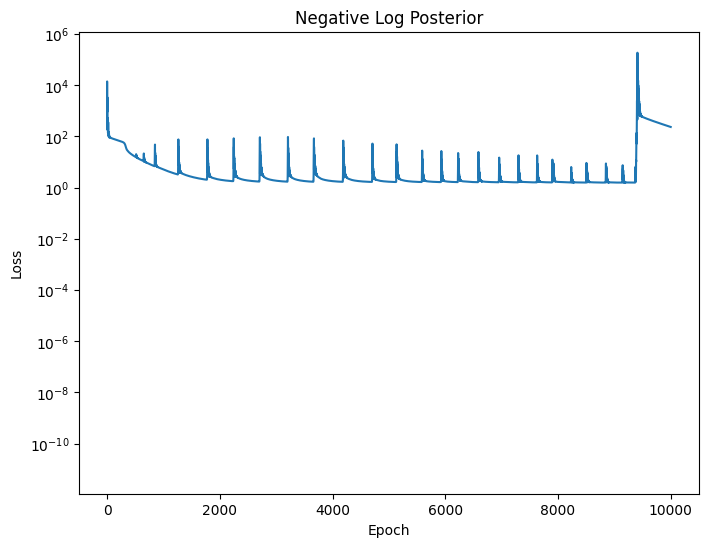

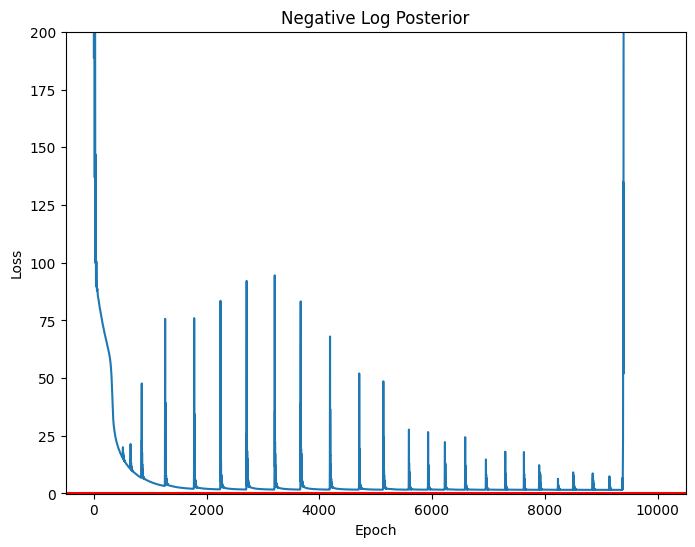

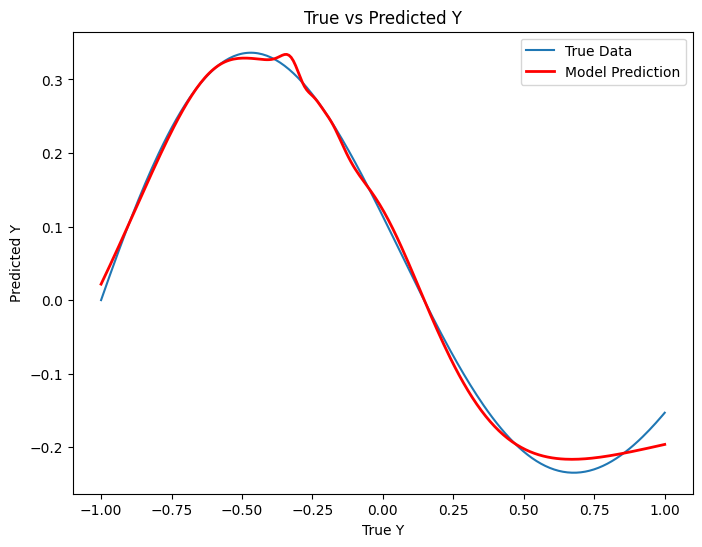

In [65]:
# Print RMSE
model.weights = MAP_weights
model.biases = MAP_biases
U_pred = model.forward(X_tf)
rmse = tf.sqrt(tf.reduce_mean(tf.square(U_tf - U_pred)))
print("Best epoch at: ", best_epoch)
print(f"RMSE: {rmse.numpy():.8f}")

# Convert loss to anti-log
print(f"Loss: {(loss.numpy()):.8f}")
print(f"Anti Log Posterior = {np.exp(loss.numpy()):.6f}")

# Plot the loss
plt.figure(figsize=(8, 6))
plt.plot(loss_all)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Negative Log Posterior")
plt.yscale('log')
plt.show()

# Plot loss at y=0 +- 0.1
plt.figure(figsize=(8, 6))
plt.plot(loss_all)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Negative Log Posterior")
plt.ylim(-0.1, 200.1)
plt.show()

# Plot true vs predicted
plt.figure(figsize=(8, 6))
plt.plot(x, U_tf, alpha=1, label='True Data')
plt.plot(x, U_pred, color='red', label='Model Prediction', linewidth=2)
plt.xlabel("True Y")
plt.ylabel("Predicted Y")
plt.title("True vs Predicted Y")
plt.legend()
plt.show()

# Next steps:
# 1. Fix the negative log posterior loss and the log scale issue giving 0.0000000000000000
# 2. Look at momentum values
# 3. Look at single weight/bias distributions
# 4. Go to PINN with new problem

In [ ]:
# Sampling;

# Initialise MAP from model parameters
model.weights = MAP_weights
model.biases = MAP_biases
MAP = model.weights + model.biases
samples = []
new_sample = []
propose_H = 0

# Hyperparameters for HMC
num_samples = 4
step_size = 0.001
num_leapfrog_steps = 3000

# Get gradients of the log posterior with respect to the model parameters
def grad_log_posterior(model, X, Y):
    with tf.GradientTape() as tape:
        Y_pred = model.forward(X)
        loss = negative_log_posterior(model, Y, Y_pred)
    return tape.gradient(loss, model.weights + model.biases)

# Hamiltonian Monte Carlo sampling
def hmc_sampling(model, X, Y, num_samples, step_size, num_leapfrog_steps):
    samples = [] # List to store samples
    current_sample = MAP # Start from the MAP estimate
    #current_log_prob = negative_log_posterior(model, Y, model.forward(X)).numpy()

    num_accepted = 0
    num_rejected = 0

    for k in range(num_samples):
        # Sample momentum from a Gaussian distribution
        momentum = [tf.random.normal(w.shape) for w in current_sample]
        '''# Plot momentum distribution
        print("Momentum size:" , momentum[1].numpy().ravel().shape)
        plt.figure(figsize=(10, 5))
        plt.hist(momentum[1].numpy().ravel(), bins=50)
        plt.title('Momentum')
        plt.show()'''

        # Compute the current and proposed log probabilities
        current_H = negative_log_posterior(model, Y, model.forward(X)).numpy() + 0.5 * sum((m**2).numpy().sum() for m in momentum)
        
        momentum_norm_list = []

        # Leapfrog integration
        new_sample = samples[-1] if samples else current_sample
        
        for l in range(num_leapfrog_steps):
            # Make a half step for momentum at the beginning
            momentum = [m - 0.5 * step_size * g for m, g in zip(momentum, grad_log_posterior(model, X, Y))]

            # Calculate the momentum norm for each weight and bias
            momentum_norm = [tf.norm(m).numpy() for m in momentum]

            # Append the momentum norm to the list
            momentum_norm_list.append(momentum_norm)

            # Make a full step for the position
            new_sample = [w + step_size * m for w, m in zip(new_sample, momentum)]
            new_sample = [tf.Variable(w) for w in new_sample] 
            model.weights = new_sample[:3]
            model.biases = new_sample[3:]
            # Make a full step for the momentum, except at the end of the trajectory
            if l < num_leapfrog_steps - 1:
                momentum = [m - 0.5 * step_size * g for m, g in zip(momentum, grad_log_posterior(model, X, Y))]

            #print("Step: ", l+1)
            #print("Momentum Norm: ", momentum_norm)
        # Plot momentum norm
        plt.figure(figsize=(10, 5))
        plt.plot(momentum_norm_list)
        plt.title('Momentum Norm')
        plt.show()

                            
        proposed_H = negative_log_posterior(model, Y, model.forward(X)).numpy() + 0.5 * sum((m**2).numpy().sum() for m in momentum)
        #print("Proposed Log Prob: ", proposed_log_prob)

        #print("h: ", current_H - proposed_H, "--------- Sample: ", k + 1)

        # Accept or reject the new sample
        p = np.random.uniform()
        alpha = min(1, np.exp(proposed_H - current_H))
        if p >= alpha: # alpha >= p  or p <= alpha
            print("Accepted")
            num_accepted = num_accepted + 1
            current_sample = new_sample
            samples.append(current_sample)
        else:
            print("Rejected")
            num_rejected = num_rejected + 1
            current_sample = current_sample

        #samples.append(current_sample)

        # Print p and alpha
        print("p: ", p, " AND alpha: ", alpha)

        # Acceptance rate
        acceptance_rate = 100 * num_accepted / (num_accepted + num_rejected)
        print("Acceptance Rate: ", acceptance_rate)
        print("-------------------------- Sample: ", k+1, "--------------------------------")

    return samples

# Perform HMC sampling
samples = hmc_sampling(model, X_tf, U_tf, num_samples, step_size, num_leapfrog_steps)

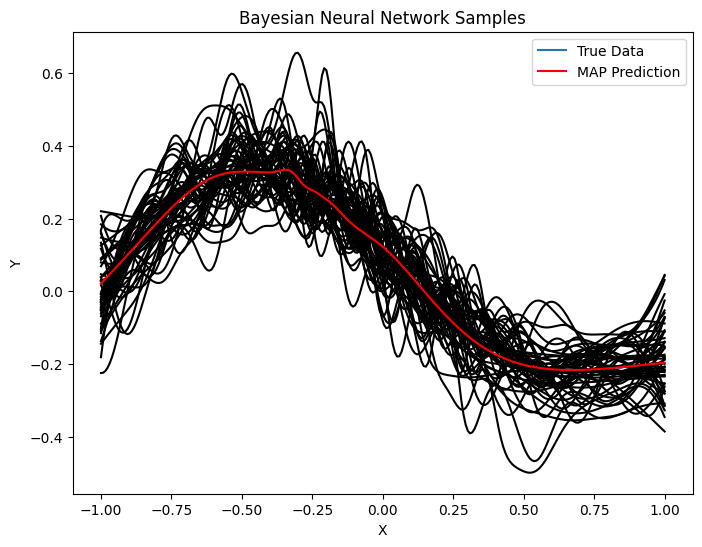

In [69]:
# Plot the samples
plt.figure(figsize=(8, 6))
plt.plot(X_tf, U_tf, alpha=1, label='True Data')
for sample in samples:
    model.weights = sample[:3]
    model.biases = sample[3:]
    U_pred = model.forward(X_tf)
    # Plot the model predictions
    if tf.sqrt(tf.reduce_mean(tf.square(U_tf - U_pred))) < 100000000:
        plt.plot(x, U_pred.numpy(), color='black', alpha=1)
model.weights = MAP_weights
model.biases = MAP_biases
plt.plot(x, model.forward(X_tf).numpy(), color='red', alpha=1, label='MAP Prediction')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Bayesian Neural Network Samples")
plt.legend()    
plt.show()

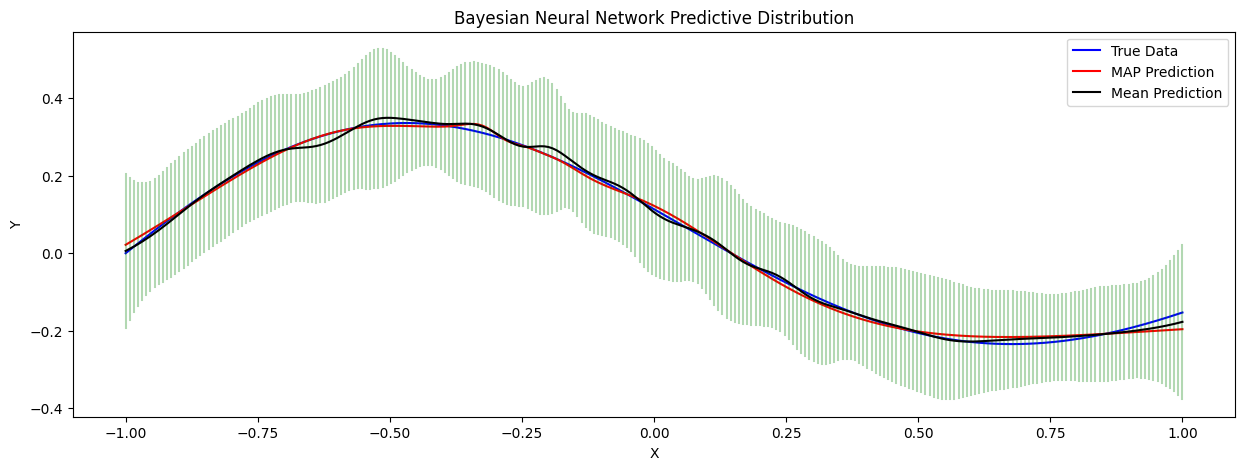

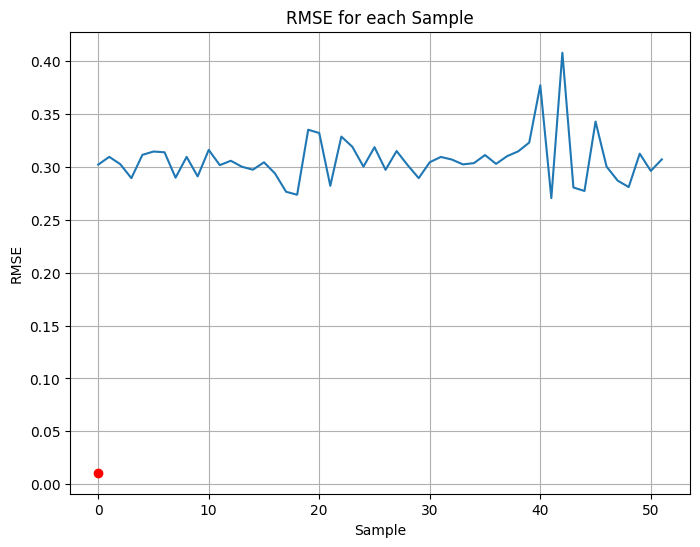

In [70]:
Y = U
X = x

# Predictive distribution;
plt.figure(figsize=(15, 5))
plt.plot(X, Y, alpha=1, color='blue', label='True Data')
model.weights = MAP_weights
model.biases = MAP_biases
plt.plot(X, model.forward(X_tf).numpy(), color='red', label='MAP Prediction')
Y_preds_sampled = []
for sample in samples:
    model.weights = sample[:3]
    model.biases = sample[3:]
    Y_pred = model.forward(X_tf)
    Y_preds_sampled.append(Y_pred)
Y_preds_sampled = np.array(Y_preds_sampled)
Y_mean = np.mean(Y_preds_sampled, axis=0)
Y_std = np.std(Y_preds_sampled, axis=0)
# Plot the confidence interval
for i in range(len(X)):
    plt.plot([X[i], X[i]], [Y_mean[i] - 2 * Y_std[i], Y_mean[i] + 2 * Y_std[i]], color='green', alpha=0.3)
plt.plot(X, Y_mean, color='black', label='Mean Prediction')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Bayesian Neural Network Predictive Distribution")
plt.legend()
plt.show()
'''
# Plot samething but zoom into x = -5 and y = 0.8 to 1.00
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(X, Y, alpha=0.3, color='blue', label='True Data')
model.weights = MAP_weights
model.biases = MAP_biases
plt.plot(X, model.forward(X_tf).numpy(), color='red', label='MAP Prediction')
Y_preds_sampled = []
for sample in samples:
    model.weights = sample[:3]
    model.biases = sample[3:]
    Y_pred = model.forward(X_tf)
    Y_preds_sampled.append(Y_pred)
Y_preds_sampled = np.array(Y_preds_sampled)
Y_mean = np.mean(Y_preds_sampled, axis=0)
Y_std = np.std(Y_preds_sampled, axis=0)
# Plot the confidence interval
for i in range(len(X)):
    plt.plot([X[i], X[i]], [Y_mean[i] - 2 * Y_std[i], Y_mean[i] + 2 * Y_std[i]], color='green', alpha=1)
plt.plot(X, Y_mean, color='black', label='Mean Prediction')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Bayesian Neural Network Predictive Distribution")
plt.legend()
plt.xlim(-5.5, -4)
plt.ylim(0.8, 1.0)

plt.subplot(1, 2, 2)
plt.plot(X, Y, alpha=0.3, color='blue', label='True Data')
model.weights = MAP_weights
model.biases = MAP_biases
plt.plot(X, model.forward(X_tf).numpy(), color='red', label='MAP Prediction')
Y_preds_sampled = []
for sample in samples:
    model.weights = sample[:3]
    model.biases = sample[3:]
    Y_pred = model.forward(X_tf)
    Y_preds_sampled.append(Y_pred)
Y_preds_sampled = np.array(Y_preds_sampled)
Y_mean = np.mean(Y_preds_sampled, axis=0)
Y_std = np.std(Y_preds_sampled, axis=0)
# Plot the confidence interval
for i in range(len(X)):
    plt.plot([X[i], X[i]], [Y_mean[i] - 2 * Y_std[i], Y_mean[i] + 2 * Y_std[i]], color='green', alpha=1)
plt.plot(X, Y_mean, color='black', label='Mean Prediction')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Bayesian Neural Network Predictive Distribution")
plt.legend()
plt.xlim(-3.5, -2)
plt.ylim(-1, 1)

plt.show()'''



# Plot RMSE for each sample
RMSEs = []
for sample in samples:
    model.weights = sample[:3]
    model.biases = sample[3:]
    Y_preds_sampled = model.forward(X_tf)
    RMSEs.append(tf.sqrt(tf.reduce_mean(tf.square(Y - Y_preds_sampled))))
plt.figure(figsize=(8, 6))
plt.plot(rmse, marker='o', linestyle='-', color='red')
plt.plot(RMSEs)
plt.grid()
plt.xlabel("Sample")
plt.ylabel("RMSE")
plt.title("RMSE for each Sample")
plt.show()